In [1]:
import numpy as np

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_uniform, init_to_median

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [12]:
n = 30
x = np.random.normal(size=[n, 1])
x = np.hstack((np.ones_like(x), x, x**2, x**3))

def expit(x):
    return 1/(1+np.exp(-x))

beta = [-1, 0.6, 0.1, 0.01,]

y = np.random.binomial(n=1, p=expit(x@beta))

rng_key = jax.random.PRNGKey(123)

In [9]:
def model(x, y):
    coef = numpyro.sample("coef", dist.Normal(0, 10), sample_shape=(len(x.shape),))
    logits = jnp.dot(x, coef)
    
    label = numpyro.sample("label", dist.Bernoulli(logits=logits), obs=y)
    print(label.shape)

In [10]:
nuts_kernel = NUTS(
    model=model,
)
mcmc = MCMC(
    sampler=nuts_kernel,
    num_warmup=5000,
    num_samples=10000,
    num_chains=1,
)
with numpyro.validation_enabled():
    posterior = mcmc.run(
        rng_key=rng_key, 
        x=x, 
        y=y,
    )
    samples = mcmc.get_samples()

TypeError: Incompatible shapes for dot: got (30, 4) and (2,).

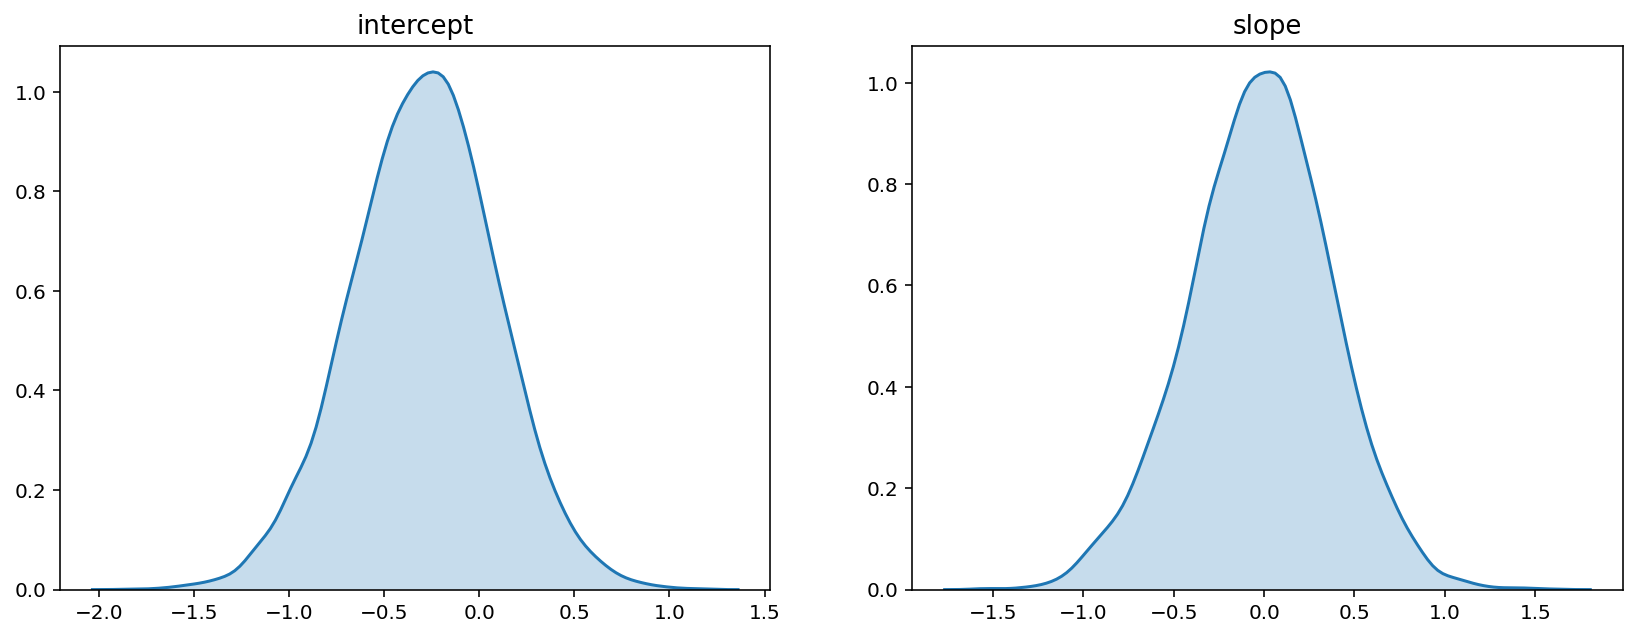

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.kdeplot(np.array(samples["coef"])[:, 0], shade=True, ax=axes[0])
_ = axes[0].set_title("intercept", fontsize=13)
sns.kdeplot(np.array(samples["coef"])[:, 1], shade=True, ax=axes[1])
_ = axes[1].set_title("slope", fontsize=13)